<a href="https://colab.research.google.com/github/SisekoC/My-Notebooks/blob/main/siamese_network_with_contrastive_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Siamese neural network with contrast loss


##Import libraries

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

##Hyperparameters

In [3]:
epochs = 10
batch_size = 16
margin = 1  # Margin of contrast loss

##Loading the MNIST collection

In [4]:
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()

# Change of data type to floating point numbers
x_train_val = x_train_val.astype('float32')
x_test = x_test.astype('float32')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


##Declaration of training and validation collection

In [5]:
x_train, x_val = x_train_val[:30000], x_train_val[30000:]
y_train, y_val = y_train_val[:30000], y_train_val[30000:]
del x_train_val, y_train_val

##Creating pairs of images

In [8]:
def make_pairs(x, y):
  num_classes = max(y) + 1
  digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

  pairs = []
  labels = []

  for idx1 in range(len(x)):
    x1 = x[idx1]
    label1 = y[idx1]
    idx2 = random.choice(digit_indices[label1])
    x2 = x[idx2]

    pairs += [[x1, x2]]
    labels += [1]

    label2 = random.randint(0, num_classes - 1)
    while label2 == label1:
      label2 = random.randint(0, num_classes - 1)

    idx2 = random.choice(digit_indices[label2])
    x2 = x[idx2]

    pairs += [[x1, x2]]
    labels += [0]

  return np.array(pairs), np.array(labels).astype('float32')

# creation of training pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# creation of validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# creation of test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [9]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]  # x_val_1.shape is (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

x_test_1 = pairs_test[:, 0]  # x_test_1.shape is (20000, 28, 28)
x_test_2 = pairs_test[:, 1]

##Visualization of pairs and their labels

In [10]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):

  num_row = to_show // num_col if to_show // num_col != 0 else 1

  to_show = num_row * num_col

  fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
  for i in range(to_show):

    if num_row == 1:
      ax = axes[i % num_col]
    else:
      ax = axes[i // num_col, i % num_col]

    ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap='gray')
    ax.set_axis_off()
    if test:
      ax.set_title('True: {} | pred: {:.5f}'.format(labels[i], predictions[i][0]))
    else:
      ax.set_title('Label: {}'.format(labels[i]))
  if test:
    plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
  else:
    plt.tight_layout(rect=(0, 0, 1.5, 1.5))
  plt.show()

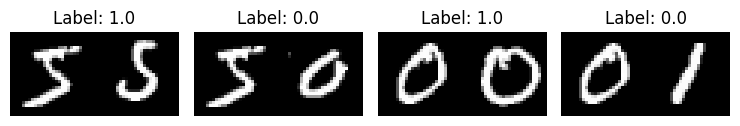

In [11]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

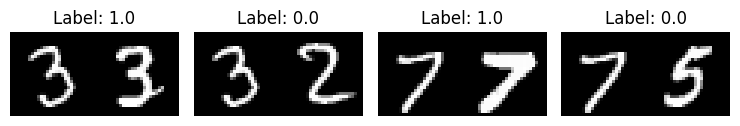

In [12]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

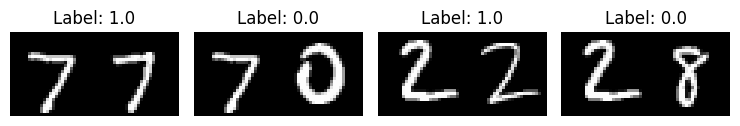

In [13]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

##Model declaration

In [15]:
def euclidean_distance(vects):
  x, y = vects
  sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
  return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

input =layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation='tanh')(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation='tanh')(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation='tanh')(x)
embedding_net = keras.Model(input, x)

input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# The Siamese network divides the weights among sister networks.
# To make this possible we will set the same embedding for both sister networks.
tower_1 = embedding_net(input_1)
tower_2 = embedding_net(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation='sigmoid')(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

##Declaration of contrast loss

In [16]:
def loss(margin=1):

  def contrastive_loss(y_true, y_pred):

    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square
    )
  return contrastive_loss

##Compilation of contrast loss model

In [17]:
siamese.compile(loss=loss(margin), optimizer='RMSProp', metrics=['accuracy'])
siamese.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 10)             │          5,318 │ input_layer_4[0][0],   │
│                           │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1)              │              0 │ functional_2[0][0],    │
│                           │                        │                │ functional_2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 1)              │              4 │ lambda_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │              2 │ batch_normalization_5… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,324 (20.80 KB)

 Trainable params: 4,808 (18.78 KB)

 Non-trainable params: 516 (2.02 KB)

##Model training

In [18]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs
)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.4825 - loss: 0.2666 - val_accuracy: 0.5000 - val_loss: 0.2500
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5100 - loss: 0.2489 - val_accuracy: 0.8812 - val_loss: 0.1167
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.8742 - loss: 0.0980 - val_accuracy: 0.9529 - val_loss: 0.0369
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9275 - loss: 0.0556 - val_accuracy: 0.9650 - val_loss: 0.0271
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9421 - loss: 0.0443 - val_accuracy: 0.9714 - val_loss: 0.0221
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9473 - loss: 0.0412 - val_accuracy: 0.9741 - val_loss: 0.0202
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9514 - loss: 0.0372 - val_accuracy: 0.9759 - val_loss: 0.0186
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9564 - loss: 0

##Visualize the results

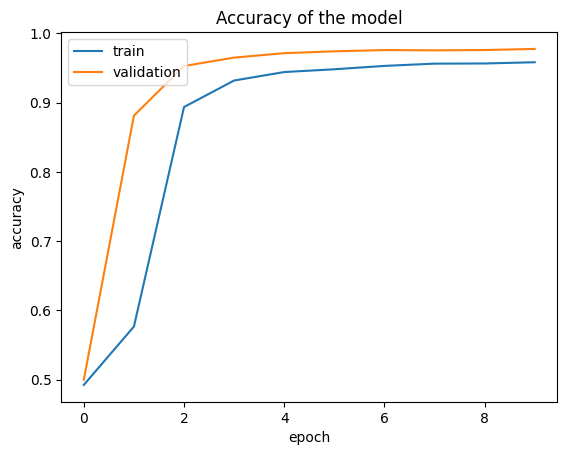

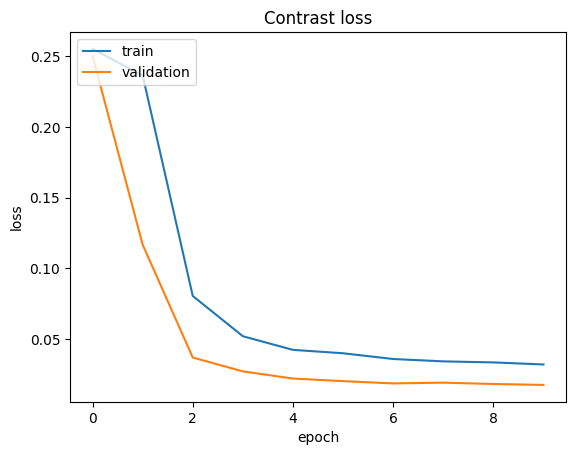

In [20]:
def plt_metric(history, metric, title, has_valid=True):

  plt.plot(history[metric])
  if has_valid:
    plt.plot(history['val_' + metric])
    plt.legend(['train', 'validation'], loc='upper left')
  plt.title(title)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.show()

plt_metric(history=history.history, metric='accuracy', title='Accuracy of the model')
plt_metric(history=history.history, metric='loss', title='Contrast loss')

In [21]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print('test loss, test acc:', results)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9788 - loss: 0.0170
test loss, test acc: [0.015345389023423195, 0.9807999730110168]


##Prediction visualization

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


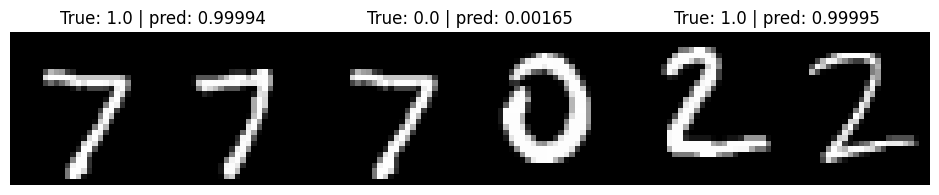

In [22]:
preds = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=preds, test=True)